In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Units: energies in meV, distance in A
# hbar2m = hbar^2 / 2m (meV * A^2), with m = mass of the partical (proton)

HBAR2M = 2.08

In [18]:
def ljPot(sigma, epsilon):
	"""
	Helper function that gives the value of Lennard-Jones potential
	as a funtion of r, if sigma and epsilon is provided
	"""
	def lj(r):
		return epsilon * ( (sigma / r)**(12) - 2 * (sigma / r)**6 )

	return lj

In [19]:
def startPoints(sigma, epsilon, r0, r1):
	"""
	Helper funtion to calculating starting point for Numerov integration
	"""
	u0 = np.exp(-1 * np.sqrt(epsilon / HBAR2M * sigma**12 / 25.0) / r0**5)
	u1 = np.exp(-1 * np.sqrt(epsilon / HBAR2M * sigma**12 / 25.0) / r1**5)

	return u0, u1

In [20]:
def jBessel(x, l):
	"""
	Recurcive calculation of j_l
	"""
	if l == -1:
		return np.cos(x) / x
	if l == 0:
		return np.sin(x) / x
	j = (2 * l - 1) / x * jBessel(x, l - 1) - jBessel(x, l - 2)	
	
	return j

In [21]:
def nBessel(x, l):
	"""
	Recurcive calculation of n_l
	"""
	if l == -1:
		return np.sin(x) / x
	if l == 0:
		return -np.cos(x) / x
	n = (2 * l - 1) / x * nBessel(x, l - 1) - nBessel(x, l - 2)	
	
	return n 

In [22]:
def phaseShift(r, y, q, i1, i2, l, energy):
	"""
	Function that calculates delta_l(E) 
	"""
	r1 = r[i1]
	r2 = r[i2]
	# Calculating kappa 
	K = ( r2 * y[i1] ) / ( r1 * y[i2])
	# Calculating phase shift
	delta_l = np.arctan( (K*jBessel(q*r2,l) - jBessel(q*r1,l)) / (K*nBessel(q*r2,l) - nBessel(q*r1,l)) )

	return delta_l

In [23]:
def numerovIntegration(rmin, rmax, mesh, l, energy):
	"""
	Numerov integration of radial Shrodinger equation
	"""
	# Initializing mesh
	r = np.zeros(mesh+1)
	r[0] = rmin
	dr = (rmax - rmin) / (mesh)
	for i in range(1, mesh+1):
		r[i] = r[0] + dr * i
	
	# Initializing potential on the mesh
	lj = ljPot(sigma = 3.57, epsilon = 5.9) 
	vpot = lj(r)

	# Calculating function f for Numerov method
	f = 1.0 - (dr**2 / 12.0) / HBAR2M * (HBAR2M * l * (l + 1) / r**2 + vpot - energy) 

	# Initializing y 
	y = np.zeros(mesh+1)
	# Calculating starting points 
	y[0], y[1] = startPoints(sigma = 3.57, epsilon = 5.9, r0 = r[0], r1 = r[1])

	# Inward integration
	for i in range(2, mesh+1):
		y[i] = ((12.0 - 10.0 * f[i-1]) * y[i-1] - f[i-2] * y[i-2]) / f[i]

	# Normalization of wave function
	norm = 0
	for i in range(mesh+1):
		norm += y[i]*y[i]*dr
	y /= np.sqrt(norm)

	return r, y

In [24]:
def printToFile(filename, res, mesh, xmin, lmax):
	"""
	Helper function that prints total crossections
	to the file "filename"
	"""
	f = open(filename, 'w')
	f.write("# mesh = %d, xmin = %f, lmax = %d\n" % (mesh, xmin, lmax)) 
	f.write("# E\t\tsigma(E)\t\tsigma_l(E), l=0, lmax\n")
	for energy, cross_tot, cross in res:
		f.write("%f\t%f\t" % (energy, cross_tot))
		for i in range(lmax+1): 
			f.write("%f\t" % cross[i])
		f.write("\n")
	
	f.close()

In [198]:
def runCrossection(silent=False):

	if not silent:
		while True:
			try:
				mesh = int(input('Number of grid points for radial integration > '))
			except ValueError:
				print ('Please, type an integer number. Typical value is several hundreds')
				continue
			else:
				break

		while True:
			try:
				rmin = float(input('Radial integration starts at (A) > '))
			except ValueError:
				print ('Please, type a float number. Typical value is 0.5 * sigma. Where sigma is from LJ potential ')
				continue
			else:
				break

		while True:
			try:
				rmax = float(input('First matching point (A) > '))
			except ValueError:
				print ('Please, type a float number. Typical value is 15 * sigma. Where sigma is from LJ potential ')
				continue
			else:
				break

		while True:
			try:
				lmax = int(input('Max l for which phase shifts are calculated > '))
			except ValueError:
				print ('Please, type an integer number. Typical value is 7-10.')
				continue
			else:
				break

		while True:
			try:
				energyRange = input('Min and Max energy, Delta E (meV) > ').split(' ')
				minE = float(energyRange[0])
				maxE = float(energyRange[1])
				deltaE = float(energyRange[2])
			except ValueError:
				print ('Please, type three numbers separated by space')
				continue
			else:
				break

		filename = input('Output data written to file > ')

	else:

		rmin = 1.6
		rmax = 40
		mesh = int((rmax-rmin)//0.05)
		lmax = 7
		minE = 1
		maxE = 10.0
		deltaE = 1
		filename = '_temp_rmin = '+str(rmin)+'_rmax = '+str(rmax)+ '_lmax =' +str(lmax)+'_step =' +str(0.05)+'.txt'
        
	# Average half-wavelength on the energy range
	# recalculating it at each energy produces some numerical noise
	waveLength = np.pi / np.sqrt( (maxE + minE) / 2.0 / HBAR2M )
	rmax = rmax + waveLength 
	
	energy = minE
	res = []
	while energy <= maxE:
		cross = (lmax+1) * [0] 
		for l in range(lmax+1):
			r, y = numerovIntegration(rmin=rmin, rmax=rmax, mesh=mesh, energy=energy, l=l)	
			dr = r[1] - r[0]
			i1 = mesh
			i2 = i1 - int(waveLength/dr)
			q = np.sqrt(energy/HBAR2M)
			delta_l = phaseShift(r=r, y=y, q=q, i1=i1, i2=i2, energy=energy, l=l)
			cross[l] += 4.0 * np.pi / q**2 * (2*l + 1) * (np.sin(delta_l))**2
		cross_tot = sum(cross)
		res.append((energy, cross_tot, cross))
		with open('wf_energy = '+str(round(energy))+'.txt', 'w') as f:
			for i in range(len(y)):
				f.write(str(r[i])+' '+str(y[i])+'\n')
		energy += deltaE

	printToFile(filename, res, mesh, rmin, lmax)
	return 0

In [199]:
assert np.floor( ljPot(sigma=3.57, epsilon=5.9)(1.6) ) == 88375.0, 'Error in ljPot' 	
#	#dr = r[1] - r[0]
#i1 = 1000
#i2 = i1 - int((17.93196915 - 16) / dr)   
#print phaseShift(r, y, i1, i2, l=1, energy=1.0)
runCrossection(silent=True)	
assert jBessel(x = 1.0, l = 7)  ==  13.0 / 1.0 * jBessel(x = 1.0, l = 6) - jBessel(x = 1.0, l = 5), 'Error in jBessel'
assert nBessel(x = 1.0, l = 7)  ==  13.0 / 1.0 * nBessel(x = 1.0, l = 6) - nBessel(x = 1.0, l = 5), 'Error in nBessel'

## Задание 1.

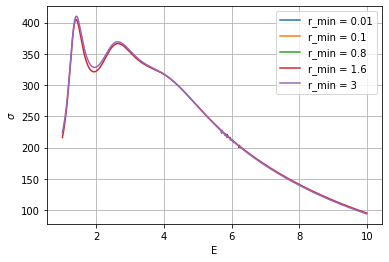

Только при таких значениях r_min, что находятся слишком близко к минимуму потенциала появляются осциляции


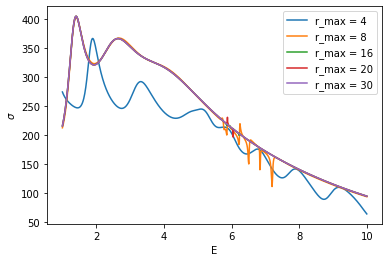

После достижения r_max такого, что в нем потенциал обращается почти в ноль, график зависимости сечения рассеяния от энергии остается неизменным


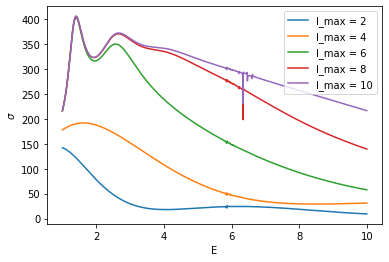

При увеличении l наблюдаем все лучшую сходимость результатов


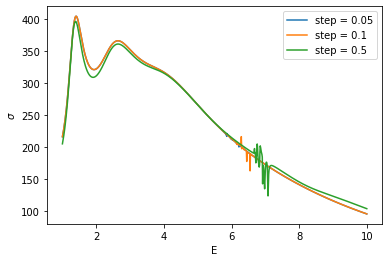

При больших значениях шага сетки появляются сильные осциляции, которые пропадают при уменьшении шага


In [305]:
r_min = [0.01, 0.1, 0.8, 1.6, 3]
r_max = [4, 8, 16, 20, 30]
l_max = [2, 4, 6, 8, 10]
step = [0.05, 0.1, 0.5]
for j in range(len(r_min)):
    e, sigma = [], []
    with open('temp_rmin = '+str(r_min[j])+'_rmax = 16_lmax =7.txt') as f:
        for i, line in enumerate(f):
            if i > 1:
                e.append(float(line.split()[0]))
                sigma.append(float(line.split()[1]))
    #             for i in range(len(line.split())-2):
    #                 sigma_l[i].append(float(line.split()[i+2]))
    plt.plot(e, sigma, label = 'r_min = '+str(r_min[j]))
    plt.xlabel('E')
    plt.ylabel('$\sigma$')
    plt.grid()
    plt.legend()
plt.show()
print('Только при таких значениях r_min, что находятся слишком близко к минимуму потенциала появляются осциляции')
for j in range(len(r_max)):
    e, sigma = [], []
    with open('temp_rmin = 1.6_rmax = '+str(r_max[j])+'_lmax =7.txt') as f:
        for i, line in enumerate(f):
            if i > 1:
                e.append(float(line.split()[0]))
                sigma.append(float(line.split()[1]))
    #             for i in range(len(line.split())-2):
    #                 sigma_l[i].append(float(line.split()[i+2]))
    plt.plot(e, sigma, label = 'r_max = '+str(r_max[j]))
    plt.xlabel('E')
    plt.ylabel('$\sigma$')
    plt.legend()
plt.show()
print('После достижения r_max такого, что в нем потенциал обращается почти в ноль, график зависимости сечения рассеяния от энергии остается неизменным')
for j in range(len(l_max)):
    e, sigma = [], []
    with open('temp_rmin = 1.6_rmax = 16_lmax ='+str(l_max[j])+'_step =0.05.txt') as f:
        for i, line in enumerate(f):
            if i > 1:
                e.append(float(line.split()[0]))
                sigma.append(float(line.split()[1]))
    #             for i in range(len(line.split())-2):
    #                 sigma_l[i].append(float(line.split()[i+2]))
    plt.plot(e, sigma, label = 'l_max = '+str(l_max[j]))
    plt.xlabel('E')
    plt.ylabel('$\sigma$')
    plt.legend()
plt.show()
print('При увеличении l наблюдаем все лучшую сходимость результатов')
for j in step:
    e, sigma = [], []
    with open('temp_rmin = 1.6_rmax = 16_lmax =7_step ='+str(j)+'.txt') as f:
        for i, line in enumerate(f):
            if i > 1:
                e.append(float(line.split()[0]))
                sigma.append(float(line.split()[1]))
    #             for i in range(len(line.split())-2):
    #                 sigma_l[i].append(float(line.split()[i+2]))
    plt.plot(e, sigma, label = 'step = '+str(j))
    plt.xlabel('E')
    plt.ylabel('$\sigma$')
    plt.legend()
plt.show()
print('При больших значениях шага сетки появляются сильные осциляции, которые пропадают при уменьшении шага')

## Задание 2.

In [222]:
import math
def psi(r, e):
    k = math.sqrt(HBAR2M/e)
    return(math.cos((r)/k))
def normal(psi, r):
    s = 0
    for i in range(len(psi)-1):
        s += psi[i]**2 * (r[i+1]-r[i])
    for j in range(len(psi)):
        psi[j] *= s**(-0.5)
    return(psi)

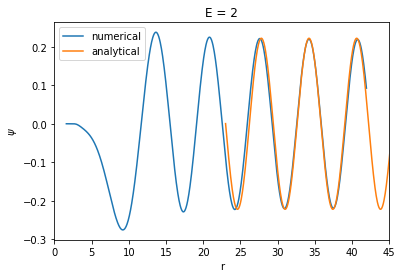

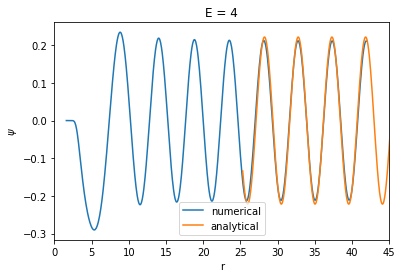

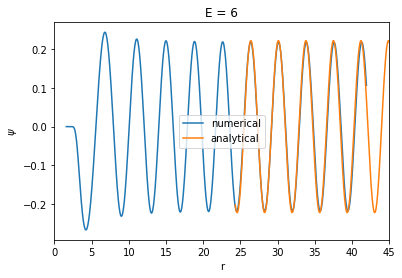

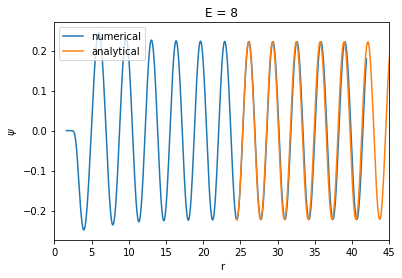

In [297]:
e = [i for i in range(2, 10, 2)]
for i in e:
    r, y = [], []
    with open('wf_energy = '+str(i)+'.txt') as f:
        for line in f:
            r.append(float(line.split()[0]))
            y.append(float(line.split()[1]))
    plt.plot(r, y, label = 'numerical')
    plt.xlabel('r')
    plt.ylabel('$\psi$')
    y1 = [psi(r[j], i) for j in range(len(r))]
    delta = [21.4, 23.7, 22.7, 22.9]
    r1 = [k+delta[(i-2)//2] for k in r]
    plt.plot(r1, normal(y1, r), label = 'analytical')
    plt.xlim(0, 45)
    plt.title('E = '+str(i))
    plt.legend()
    plt.show()
    #plt.plot(r, y1, label = str(i))
    #print(math.sqrt(2*math.pi/HBAR2M), i)

Как мы можем наблюдать из графиков зависимости потенциала от координаты, около 25 можно сказать, что для каждого l потенциал обращается в ноль. Соответственно, начиная с этого значения координаты можем аппроксимировать решение плоской волной. Как видим, численный и аналитический результаты в таком случае совпадают. 

## Задание 3.

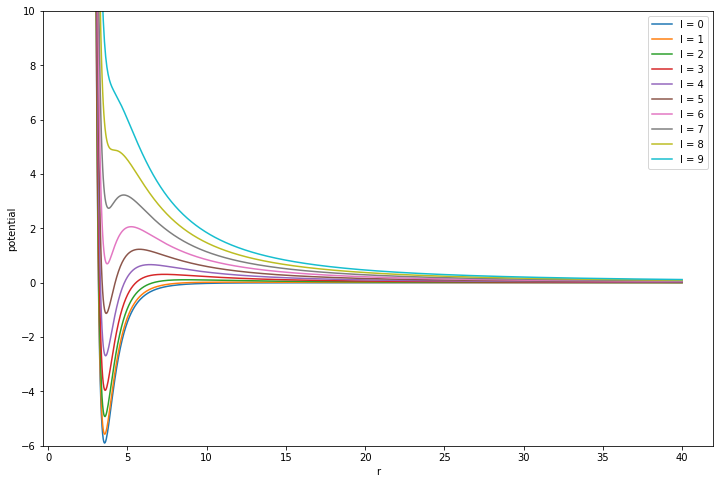

In [304]:
def potential(r, l):
    lj = ljPot(sigma = 3.57, epsilon = 5.9) 
    vpot = lj(r)

# Calculating function f for Numerov method
    return HBAR2M * l * (l + 1) / r**2 + vpot
r = np.linspace(1.6, 40, 1000)
#p = [potential(r) for i in range(len(r))]
plt.figure(figsize = (12, 8))
for l in range(10):
    plt.plot(r, potential(r, l), label = 'l = '+str(l))
plt.ylim(-6, 10)
plt.xlabel('r')
plt.ylabel('potential')
plt.legend()

Начиная с некоторого l(4) в зависимости потенциала от координаты появляется локальный максимум. Для частицы, обладающей энергией равной энергии в данном максимуме, это r будет служить классической точкой поворота. Чем более пологий максимум, тем в большем диапазоне r частицы с данной энергией будут рассеиваться. Следовательно, при этой энергии будет наблюдаться эффективное рассеяние, что и объясняет пики на предыдущих графиках. При l >= 8 данный максимум пропадает, также как и пики на зависимости сечения от энергии. 